# Real NVP

In [6]:
# Import required packages
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] ="false"
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import learning.module.normalizing_flow as nf
from learning.module.networks import MLP
from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
# Set up model

# Define flows
K = 64
seed=10
latent_size = 2
b = jnp.asarray([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(K):
    s = MLP([latent_size, 2 * latent_size, latent_size], activation=nn.leaky_relu, kernel_init=jax.nn.initializers.zeros)
    t = MLP([latent_size, 2 * latent_size, latent_size], activation=nn.leaky_relu, kernel_init=jax.nn.initializers.zeros)
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.AffineConstFlow((latent_size,))]

# Set target and q0
target = nf.distributions.TwoModes(2, 0.1)
q0 = nf.distributions.DiagGaussian((2,))

# Construct flow model
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)

rng = jax.random.PRNGKey(seed)
x0 = jnp.zeros((8, 2))   # any batch size; shape must be (N, 2)
key_sample, rng_params, rng = jax.random.split(rng,3)

# flow_params = nfm.init(rng_params, mode='sample', num_samples=1024, rng=key_sample)
flow_params = nfm.init(rng_params, mode='log_prob', x=jnp.ones((4,2)))

# Use it
x, log_q = nfm.apply(flow_params, mode='sample', num_samples=1024, rng=key_sample)
lp = nfm.apply(flow_params, mode='log_prob', x=jnp.ones((4, 2)))
fkld = nfm.apply(flow_params, mode='forward_kld', x=jax.random.normal(jax.random.PRNGKey(2), (128, 2)))
rkld = nfm.apply(flow_params, mode='reverse_kld', num_samples=512, rng=key_sample)

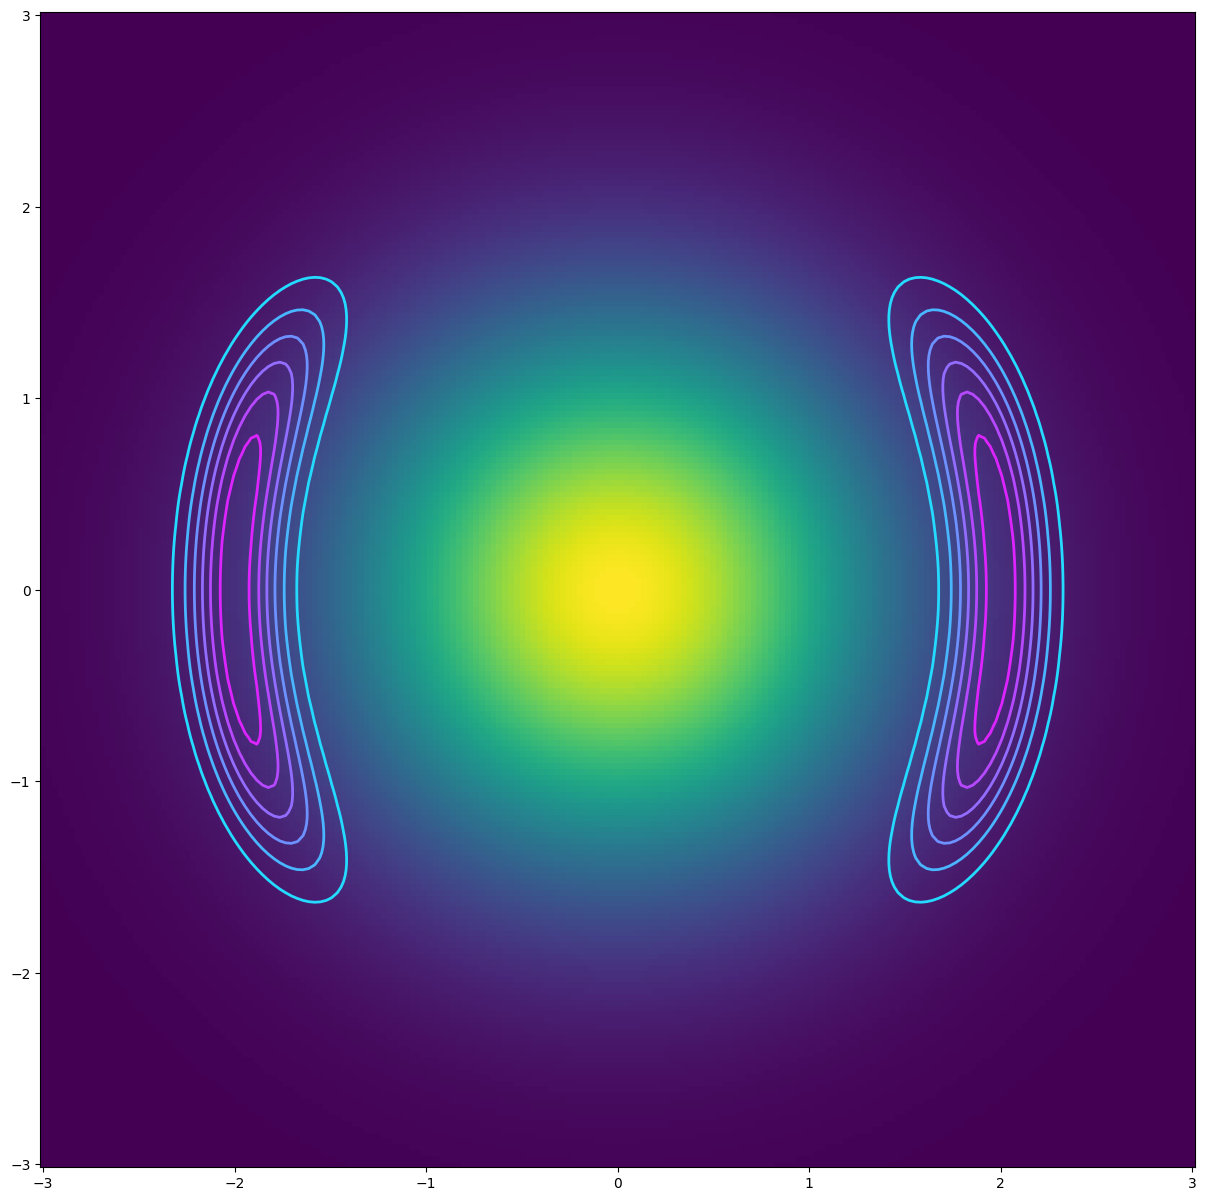

In [ ]:
# Plot target distribution
grid_size = 200
lin = jnp.linspace(-3.0, 3.0, grid_size)
yy, xx = jnp.meshgrid(lin, lin, indexing="xy")          # (G, G)
zz = jnp.reshape(jnp.stack([xx, yy], axis=-1),(-1,2))                  # (G, G, 2)

log_prob = target.log_prob(zz).reshape(*xx.shape)
prob_target = jnp.exp(log_prob)

# Plot initial posterior distribution
log_prob = nfm.apply(flow_params, x=zz, mode="log_prob").reshape(*xx.shape)
prob = jnp.exp(log_prob)

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob)
plt.contour(xx, yy, prob_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

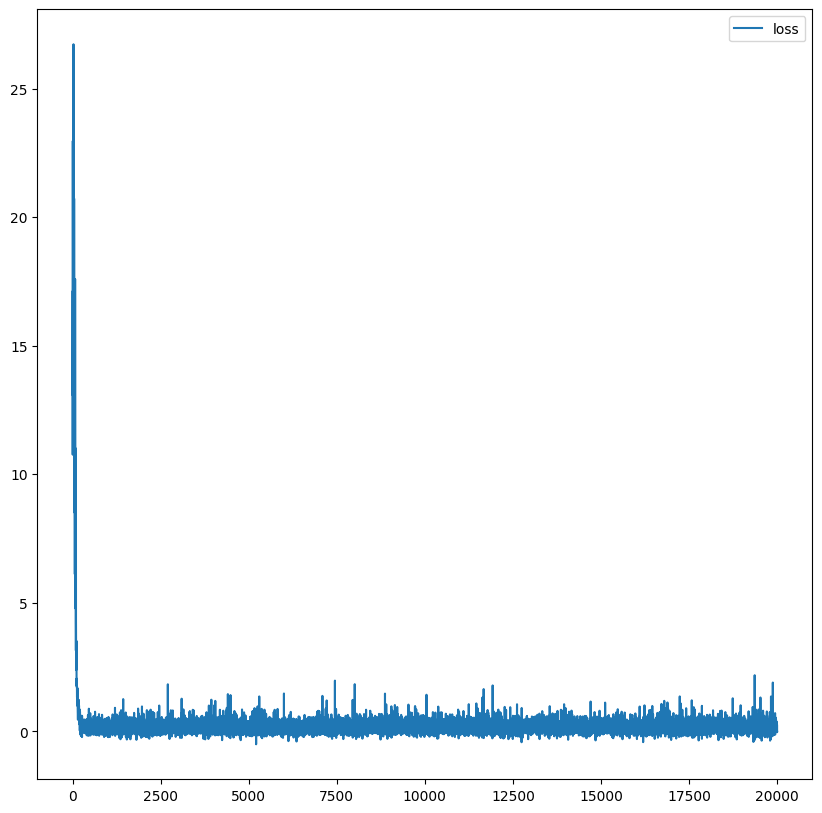

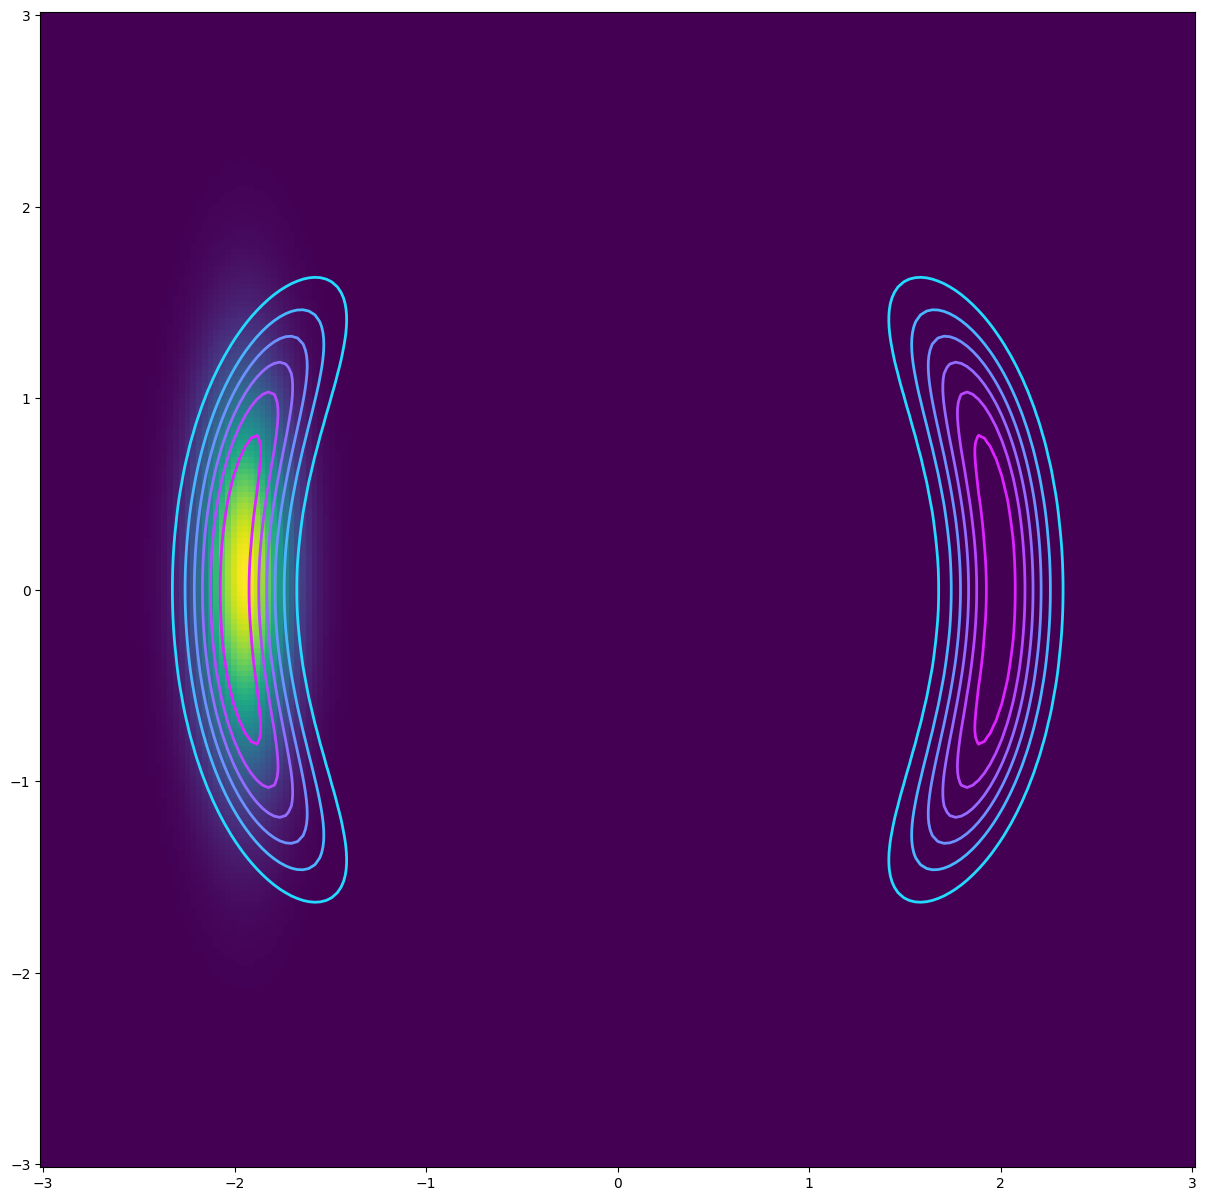

In [ ]:
import functools
import optax
# Train model
max_iter = 20000
num_samples = 2 * 10
anneal_iter = 10000
annealing = True
show_iter = 1000


def loss_fn(params, key, beta):
    # 'mode' and 'num_samples' stay constant => no recompile
    return nfm.apply(params,
                     mode='reverse_kld',
                     num_samples=num_samples, rng=key)
# precompute annealing schedule on device (no Python math in step)
betas = jnp.linspace(0.01, 1.0, anneal_iter)
betas = jnp.concatenate([betas, jnp.full((max_iter - anneal_iter,), 1.)])
@functools.partial(jax.jit, donate_argnums=(0, 1))
def train_step(params, opt_state, base_key, beta):
    # derive per-iter key deterministically from base_key and beta (or an index)
    # if you prefer by iteration index, pass it instead and fold_in(it)
    key = jax.random.fold_in(base_key, jnp.round(beta * 1e6).astype(jnp.int32))
    loss, grads = jax.value_and_grad(loss_fn)(params, key, beta)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss
def body_fn(it, carry):
    params, opt_state, base_key, loss_buf = carry
    base_key, key = jax.random.split(base_key)
    beta = betas[it]
    params, opt_state, loss = train_step(params, opt_state, key, beta)
    loss_buf = loss_buf.at[it].set(loss)
    return (params, opt_state, base_key, loss_buf)
# flow_params = nfm.init(rng_params, mode='sample', num_samples=1024, rng=key_sample)
rng, rng_params = jax.random.split(rng)
flow_params = nfm.init(rng_params, mode='log_prob', x=x0)
loss_hist = np.array([])
optimizer = optax.adamw(learning_rate=1e-3) # weight_decay = 1e-4)
opt_state = optimizer.init(flow_params)
loss_buf = jnp.zeros((max_iter,), dtype=jnp.float32)
flow_params, opt_state, rng, loss_buf = jax.lax.fori_loop(
    0, max_iter, body_fn, (flow_params, opt_state, rng, loss_buf)
)
loss_hist = jnp.asarray(loss_buf).copy()
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

log_prob = nfm.apply(flow_params, method="log_prob", x=zz).reshape(*xx.shape)
prob = jnp.exp(log_prob)

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob)
plt.contour(xx, yy, prob_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()


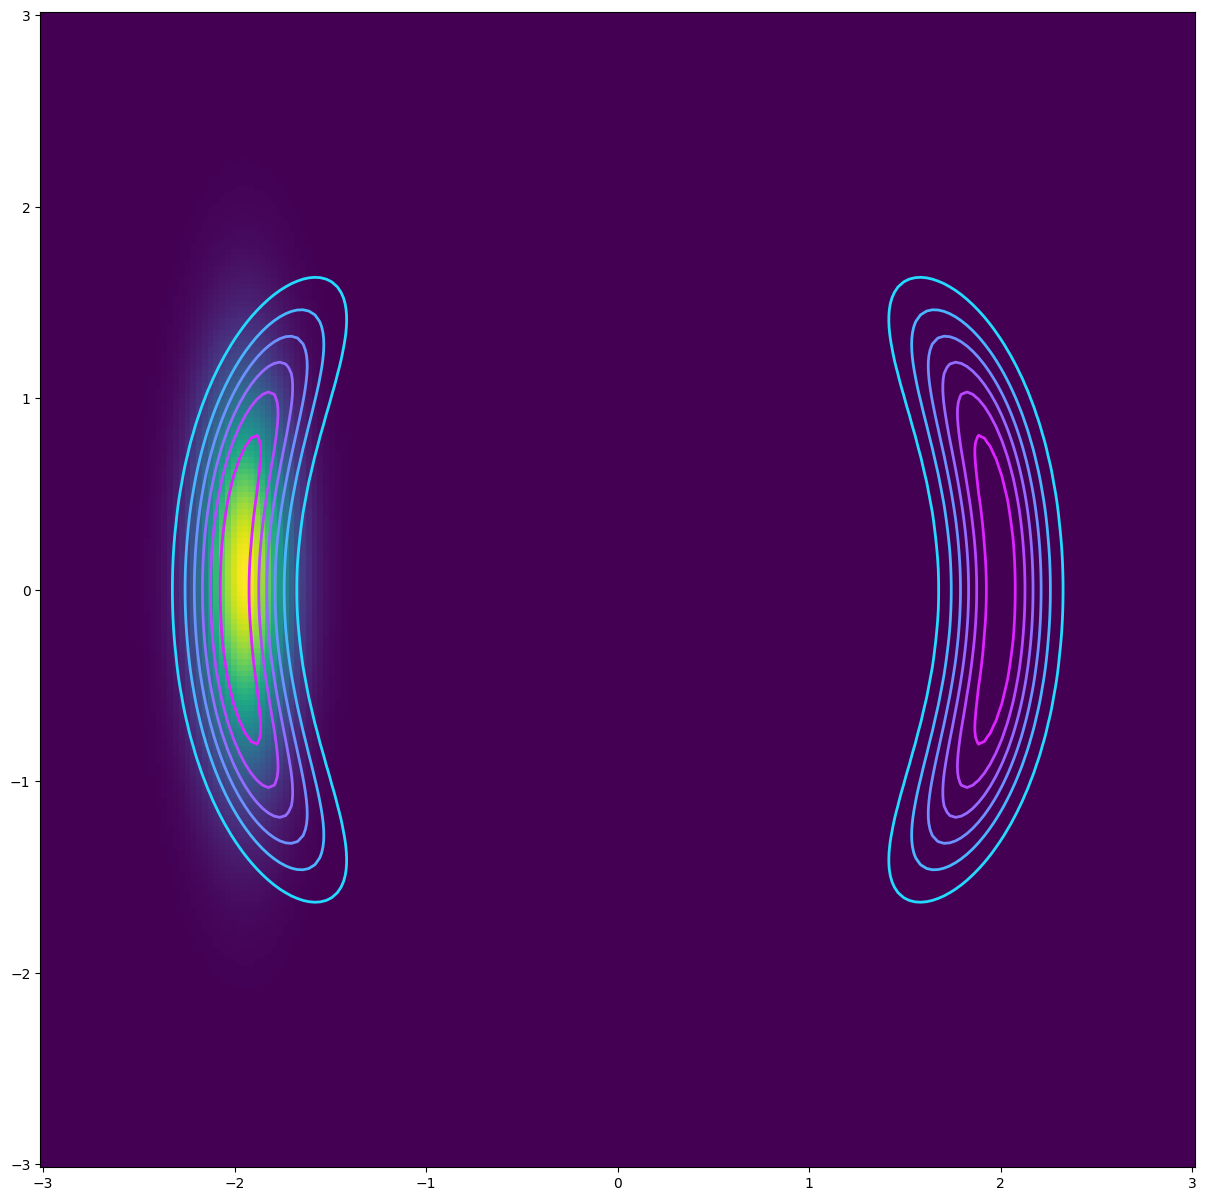

In [ ]:
log_prob = nfm.apply(flow_params, method="log_prob", x=zz).reshape(*xx.shape)
prob = jnp.exp(log_prob)

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob)
plt.contour(xx, yy, prob_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()